In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime
import os.path
import backtrader as bt
import numpy as np
from pprint import pformat
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sys
import random

sys.path.append('../..')
from decisivealpha.montecarlo import MonteCarlo

## Strategy

In [3]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('af', 0.02),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(period=self.params.maperiod)
        # Add a psar
        self.psar = bt.indicators.ParabolicSAR(af=self.params.af)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0] and self.dataclose[0] > self.psar[0]:
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0] and self.dataclose[0] < self.psar[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.thevalue = self.broker.get_value()
        self.thecash = self.broker.get_cash()
        self.log('MA Period %2d, AF %.2f, Ending Value %.2f' %
                 (self.params.maperiod, self.params.af, self.broker.getvalue()), doprint=True)

# Analyzer

In [4]:
class DecisiveAnalyzer(bt.Analyzer):
    
    def __init__(self):
        self.maperiod = self.strategy.params.maperiod
        self.af = self.strategy.params.af
        self.equity = []
        self.equitydf = pd.DataFrame()

    def start(self):
        # Not needed ... but could be used
        self.init_cash = self.strategy.broker.cash 
        self.num_trades = 0
        self.first_trade_open = None

    def next(self):
        # Not needed ... but could be used
        pass

    def notify_trade(self, trade):
        if not self.first_trade_open:
            self.first_trade_open = self.strategy.datetime.datetime()
            self.equitydf.at[self.first_trade_open, 'equity'] = self.init_cash

        if trade.isclosed:
            self.num_trades += 1
            self.equitydf.at[self.strategy.datetime.datetime(), 'equity'] = self.strategy.broker.getvalue()
            
    def stop(self):
        self.final_cash = self.strategy.broker.cash
        self.final_val = self.strategy.broker.get_value()

    def get_analysis(self):
        # Add trade profit to dataframe
        self.equitydf['net_profit'] = self.equitydf['equity'].diff()

        outp = {
            'params': (self.maperiod, self.af), 
            'profit': self.final_val - self.init_cash,
            'num_trades': self.num_trades,
            'equitydf': self.equitydf,
        }
        
        return outp

In [5]:
def best_result_from_cerebro_opti_run(result):
    params  = []
    n_trades = []
    profit   = []
    trades   = []
    for res in result:
        r = res[0].analyzers.decisive.get_analysis()
        params.append(r['params'])
        n_trades.append(r['ntrade'])
        profit.append(r['profit'])
        trades.append(r['trades'])

    prof_ind = np.argmax(profit) 
    best_params = params[prof_ind]
    best_profit = profit[prof_ind]
    best_ntrades = n_trades[prof_ind]
    best_trades = trades[prof_ind]
    
    print('best:{} profit:{} trades:{}'.format(best_params, best_profit, best_ntrades))
    return (best_params, best_profit, best_ntrades, best_trades)

## Parameter Settings

In [6]:
fname_symbol = 'CL'
folder_name = '5min'
suffix = '5min_20160103_20190405'

df = pd.read_parquet(os.path.join('../data/processed/{}/'.format(folder_name), '{}_{}.parquet'.format(fname_symbol, suffix)))
df = (df.resample('4h', label='left', base=18).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}))
df.columns = [col_name.lower() for col_name in df.columns]
df = df.dropna()
# df['2017-01-01':'2017-04-01']['close'].plot()

In [7]:
periods = [
{'run': 0, 'oos': ('2017-04-01', '2017-05-01'), 'is': ('2017-01-01', '2017-04-01')},
{'run': 1, 'oos': ('2017-05-01', '2017-06-01'), 'is': ('2017-02-01', '2017-05-01')},
{'run': 2, 'oos': ('2017-06-01', '2017-07-01'), 'is': ('2017-03-01', '2017-06-01')},
{'run': 3, 'oos': ('2017-07-01', '2017-08-01'), 'is': ('2017-04-01', '2017-07-01')},
{'run': 4, 'oos': ('2017-08-01', '2017-09-01'), 'is': ('2017-05-01', '2017-08-01')},
{'run': 5, 'oos': ('2017-09-01', '2017-10-01'), 'is': ('2017-06-01', '2017-09-01')},
{'run': 6, 'oos': ('2017-10-01', '2017-11-01'), 'is': ('2017-07-01', '2017-10-01')},
{'run': 7, 'oos': ('2017-11-01', '2017-12-01'), 'is': ('2017-08-01', '2017-11-01')},
{'run': 8, 'oos': ('2017-12-01', '2018-01-01'), 'is': ('2017-09-01', '2017-12-01')},
{'run': 9, 'oos': ('2018-01-01', '2018-02-01'), 'is': ('2017-10-01', '2018-01-01')},
{'run': 10, 'oos': ('2018-02-01', '2018-03-01'), 'is': ('2017-11-01', '2018-02-01')},
{'run': 11, 'oos': ('2018-03-01', '2018-04-01'), 'is': ('2017-12-01', '2018-03-01')},
{'run': 12, 'oos': ('2018-04-01', '2018-05-01'), 'is': ('2018-01-01', '2018-04-01')},
{'run': 13, 'oos': ('2018-05-01', '2018-06-01'), 'is': ('2018-02-01', '2018-05-01')},
]

## Data loading and strat execution

In [8]:
# class FixedSlippageAndCommisionScheme(bt.CommInfoBase):
#     '''Use this for both slippage and commissions together'''
#     params = (
#         ('commission', 12),
#         ('stocklike', True),
#         ('commtype', bt.CommInfoBase.COMM_FIXED),
#         )

#     def _getcommission(self, size, price, pseudoexec):
#         return self.p.commission

In [9]:
start_date = periods[0]['is'][0]
end_date = periods[-1]['is'][1]
print('Start/End: {} - {}'.format(start_date, end_date))

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
strats = cerebro.optstrategy(
    TestStrategy,
    maperiod=range(10, 31, 5),
    af=np.arange(0.02,0.1, 0.02))

cerebro.addanalyzer(DecisiveAnalyzer, _name='decisive')

# Set our desired cash start
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
cerebro.optreturn = False 
cerebro.broker.setcommission(commission=0.0)

# We're trading futures, so we'll use the "commissions" to handle both slippage and commissions
# slippage_and_comms = FixedSlippageAndCommisionScheme()
# cerebro.broker.addcommissioninfo(slippage_and_comms)
# Alternatively, you can use:
# cerebro.broker.set_slippage_fixed(.00,  slip_open=True, slip_limit=True, slip_match=True, slip_out=TrueS)


data = bt.feeds.PandasData(dataname = df[start_date:end_date])
cerebro.adddata(data)
# Print out the final result
results = cerebro.run(maxcpus=1)
# Print out the final result
# cerebro.plot(volume=False, iplot=True, style='candle')

Start/End: 2017-01-01 - 2018-05-01
2018-05-01, MA Period 10, AF 0.02, Ending Value 108680.00
2018-05-01, MA Period 10, AF 0.04, Ending Value 105890.00
2018-05-01, MA Period 10, AF 0.06, Ending Value 107230.00
2018-05-01, MA Period 10, AF 0.08, Ending Value 106840.00
2018-05-01, MA Period 15, AF 0.02, Ending Value 108740.00
2018-05-01, MA Period 15, AF 0.04, Ending Value 110480.00
2018-05-01, MA Period 15, AF 0.06, Ending Value 112630.00
2018-05-01, MA Period 15, AF 0.08, Ending Value 114160.00
2018-05-01, MA Period 20, AF 0.02, Ending Value 110440.00
2018-05-01, MA Period 20, AF 0.04, Ending Value 112930.00
2018-05-01, MA Period 20, AF 0.06, Ending Value 110970.00
2018-05-01, MA Period 20, AF 0.08, Ending Value 113330.00
2018-05-01, MA Period 25, AF 0.02, Ending Value 111070.00
2018-05-01, MA Period 25, AF 0.04, Ending Value 109270.00
2018-05-01, MA Period 25, AF 0.06, Ending Value 107220.00
2018-05-01, MA Period 25, AF 0.08, Ending Value 110100.00
2018-05-01, MA Period 30, AF 0.02, En

## OOS Params

In [9]:
# Get in-sample and out-of-sample best parameters with correct pre-allocation
for period in periods:
    # Get the insample time period
    insample_start = period['is'][0]
    insample_end = period['is'][1]
    print('In-Sample Period: {} - {}'.format(insample_start, insample_end))
    
    # Put the best parameters and best profit into a list
    period_netprofit = []
    for result in results:
        r = result[0].analyzers.decisive.get_analysis()
        df = r['equitydf']
        maperiod = r['params']
        
        period_profit = df[insample_start:insample_end]['net_profit'].sum()
        print('\tparams {}: {}'.format(maperiod, period_profit))
        period_netprofit.append((maperiod, period_profit))
        
    # Get the best profit parameters
    max_set = max(period_netprofit, key=lambda x:x[1])
    max_maperiod, max_profit = max_set
    
    # Add it to the dictionary
    print('\t\tBest is: {} with {} profit'.format(max_maperiod, max_profit))
    period['best_insample_param'] = max_maperiod
    period['best_insample_profit'] = max_profit

In-Sample Period: 2017-01-01 - 2017-04-01
	params (10, 0.02): -2680.0
	params (10, 0.04): -4910.0
	params (10, 0.06): -4210.0
	params (10, 0.08): -5990.0
	params (15, 0.02): -3750.0
	params (15, 0.04): -5460.0
	params (15, 0.06): -5590.0
	params (15, 0.08): -5270.0
	params (20, 0.02): -4530.0
	params (20, 0.04): -6010.0
	params (20, 0.06): -6660.0
	params (20, 0.08): -7190.0
	params (25, 0.02): -5450.0
	params (25, 0.04): -7450.0
	params (25, 0.06): -7310.0
	params (25, 0.08): -7210.0
	params (30, 0.02): -5690.0
	params (30, 0.04): -6410.0
	params (30, 0.06): -6190.0
	params (30, 0.08): -6800.0
		Best is: (10, 0.02) with -2680.0 profit
In-Sample Period: 2017-02-01 - 2017-05-01
	params (10, 0.02): 790.0
	params (10, 0.04): -2220.0
	params (10, 0.06): -500.0
	params (10, 0.08): -2710.0
	params (15, 0.02): 1780.0
	params (15, 0.04): -410.0
	params (15, 0.06): 110.0
	params (15, 0.08): 90.0
	params (20, 0.02): 590.0
	params (20, 0.04): -160.0
	params (20, 0.06): 690.0
	params (20, 0.08): 3

## Walkforward Efficiency

In [10]:
def days_from_date_tuple(mytuple):
    """Get days between dates to annualize"""
    days_start = datetime.datetime.strptime(mytuple[0], '%Y-%m-%d')
    days_end = datetime.datetime.strptime(mytuple[1], '%Y-%m-%d')
    days = (days_end - days_start).days
    return days

# Get in-sample and out-of-sample best parameters with correct pre-allocation
all_walkforward_efficiency = []
for period in periods:
    # Get the insample time period
    oos_start = period['oos'][0]
    oos_end = period['oos'][1]
    insample_profit = period['best_insample_profit']
    print('Out-of-Sample Period: {} - {}'.format(oos_start, oos_end))
    
    # Find the set of results that has the same best parameters
    target_result = None
    for result in results:
        r = result[0].analyzers.decisive.get_analysis()
        if r['params'] == period['best_insample_param']:
            target_result = r
            break
            
    # Get the equity curve of this best parameter
    target_df = target_result['equitydf']
    
    # Splice to the OOS date range only
    oos_profit = target_df[oos_start:oos_end]['net_profit'].sum()
    
    # Annualize the profit
    insample_days = days_from_date_tuple(period['is'])
    oos_days = days_from_date_tuple(period['oos'])

    insample_annual_profit = 365/insample_days * insample_profit
    oos_annual_profit = 365/oos_days * oos_profit
 
    # Calculate WFE
    period_wfe = insample_annual_profit * 100 / oos_annual_profit
    period['wfe'] = period_wfe
    all_walkforward_efficiency.append(period_wfe)
    
    print('\t Period Profit IS:{:0.2f} / OOS:{:0.2f}'.format(insample_profit, oos_profit))
    print('\t Annual Profit IS:{:0.2f} / OOS:{:0.2f}'.format(insample_annual_profit, oos_annual_profit))

    print('\t WFE: {:0.1f}%'.format(period_wfe))



wfe = sum(all_walkforward_efficiency) / len(all_walkforward_efficiency) 
print('Overall WFE: {:0.1f}%'.format(wfe))

Out-of-Sample Period: 2017-04-01 - 2017-05-01
	 Period Profit IS:-2680.00 / OOS:2240.00
	 Annual Profit IS:-10868.89 / OOS:27253.33
	 WFE: -39.9%
Out-of-Sample Period: 2017-05-01 - 2017-06-01
	 Period Profit IS:1780.00 / OOS:-1590.00
	 Annual Profit IS:7300.00 / OOS:-18720.97
	 WFE: -39.0%
Out-of-Sample Period: 2017-06-01 - 2017-07-01
	 Period Profit IS:3980.00 / OOS:-1980.00
	 Annual Profit IS:15790.22 / OOS:-24090.00
	 WFE: -65.5%
Out-of-Sample Period: 2017-07-01 - 2017-08-01
	 Period Profit IS:4770.00 / OOS:5250.00
	 Annual Profit IS:19132.42 / OOS:61814.52
	 WFE: 31.0%
Out-of-Sample Period: 2017-08-01 - 2017-09-01
	 Period Profit IS:5820.00 / OOS:-3810.00
	 Annual Profit IS:23090.22 / OOS:-44859.68
	 WFE: -51.5%
Out-of-Sample Period: 2017-09-01 - 2017-10-01
	 Period Profit IS:-760.00 / OOS:3160.00
	 Annual Profit IS:-3015.22 / OOS:38446.67
	 WFE: -7.8%
Out-of-Sample Period: 2017-10-01 - 2017-11-01
	 Period Profit IS:6870.00 / OOS:70.00
	 Annual Profit IS:27255.98 / OOS:824.19
	 WFE

## Walkforward Equity Curve

In [11]:
# Create a Stratey
class WalkforwardStrategy(bt.Strategy):

    params = (
        ('maperiod', 15),
        ('af', 0.02),
        ('printlog', False),
        ('live', False),
        ('walkforward', None),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)
        self.psar = bt.indicators.ParabolicSAR(af=self.params.af)

        
        # Trim the indicators if we are running live, just need the current one
        if not self.params.live:
            pass
        
        
        self.current_row = None
        self.wfsma = []
        
        if self.params.walkforward:
            for run in self.params.walkforward:
                self.wfsma.append({
                    'sma': bt.indicators.SimpleMovingAverage(self.datas[0], period=run['best_insample_param'][0]),
                    'psar': bt.indicators.ParabolicSAR(self.datas[0], af=run['best_insample_param'][1]),
                    'test_period': run['oos'],
                    'train_param': run['best_insample_param'],
                }) 

        print(pformat(self.wfsma))
        
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):

        # Walk-forward logic
        for row in self.wfsma:
            start, end = row['test_period']
            period_start = datetime.datetime.strptime(start, '%Y-%m-%d')
            period_end = datetime.datetime.strptime(end, '%Y-%m-%d')
            if self.datetime.datetime() >= period_start and self.datetime.datetime() < period_end:
                self.current_row = row
        
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.current_row['sma'][0] and self.dataclose[0] > self.current_row['psar'][0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.current_row['sma'][0] and self.dataclose[0] < self.current_row['psar'][0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('maperiod:%2d, %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)

In [12]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(WalkforwardStrategy, 
                    maperiod=15, 
                    walkforward=periods,
                    live=False)

# Load data
fname_symbol = 'CL'
folder_name = '5min'
suffix = '5min_20160103_20190405'

df = pd.read_parquet(os.path.join('../data/processed/{}/'.format(folder_name), '{}_{}.parquet'.format(fname_symbol, suffix)))
df = (df.resample('4h', label='left', base=18).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}))
df.columns = [col_name.lower() for col_name in df.columns]
df = df.dropna()

# periods
start_date = periods[0]['oos'][0]
end_date = periods[-1]['oos'][0]

print('Start: {} End: {}'.format(start_date, end_date))
data = bt.feeds.PandasData(dataname = df[start_date:end_date])


# Add the Data Feed to Cerebro
cerebro.adddata(data)
cerebro.addanalyzer(DecisiveAnalyzer, _name='decisive')

# Set our desired cash start
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
results = cerebro.run()

Start: 2017-04-01 End: 2018-05-01
Starting Portfolio Value: 100000.00
[{'psar': <backtrader.indicators.psar.ParabolicSAR object at 0x00000276EF4DA9B0>,
  'sma': <backtrader.indicators.sma.SimpleMovingAverage object at 0x00000276EF469908>,
  'test_period': ('2017-04-01', '2017-05-01'),
  'train_param': (10, 0.02)},
 {'psar': <backtrader.indicators.psar.ParabolicSAR object at 0x00000276EF4DAF60>,
  'sma': <backtrader.indicators.sma.SimpleMovingAverage object at 0x00000276EF4DAB70>,
  'test_period': ('2017-05-01', '2017-06-01'),
  'train_param': (15, 0.02)},
 {'psar': <backtrader.indicators.psar.ParabolicSAR object at 0x00000276EF4DE550>,
  'sma': <backtrader.indicators.sma.SimpleMovingAverage object at 0x00000276EF4DE160>,
  'test_period': ('2017-06-01', '2017-07-01'),
  'train_param': (25, 0.08)},
 {'psar': <backtrader.indicators.psar.ParabolicSAR object at 0x00000276EF4DEB00>,
  'sma': <backtrader.indicators.sma.SimpleMovingAverage object at 0x00000276EF4DE710>,
  'test_period': ('2017

Final Portfolio Value: 110430.00


c:\users\dmartens\appdata\local\continuum\anaconda3\envs\decisiveworkflowresearch\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Equity')

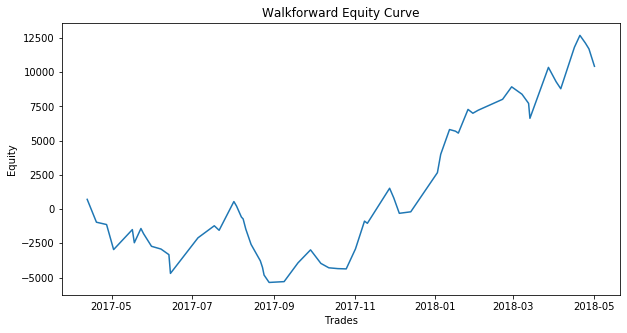

In [13]:
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
r = results[0].analyzers.decisive.get_analysis()
cumsum = r['equitydf']['net_profit'].cumsum()

plt.figure(figsize=(10,5))
plt.plot(cumsum)
plt.title('Walkforward Equity Curve')
plt.xlabel('Trades')
plt.ylabel('Equity')

# cerebro.plot(volume=False, iplot=True, style='candle')

## MonteCarlo


In [14]:
# Assume CL futures margin
margin = 5000

start_date = datetime.date(2016, 1, 1)
end_date = datetime.date(2018, 1, 1)

In [18]:
# We're going to generate a random list of trades,
# and you should replace this with your walkforward list of trades
mc = MonteCarlo(r['equitydf']['net_profit'].values[1:])

# We will sample with replacement the number of trades per year
# so we need the start and end date to determine how many trades at in a year on average
mc.settings(margin, start_date, end_date)

# Test different levels of equity starting at this value
trial_starting_equity = int(margin * 1.5)

# Run the Monte Carlo
results = mc.run(trial_starting_equity)

In [19]:
# Put the results in a dataframe so it's nicer to look at in notebook
# Our goal is to get the highest equity below 10% Risk of Ruin
df = pd.DataFrame(index=range(1,len(results)))
count = 1
for result in results:
    df.loc[count, 'equity'] = result['equity']
    df.loc[count, 'is_ruined'] = result['is_ruined']
    df.loc[count, 'is_profitable'] = result['is_profitable']
    df.loc[count, 'returns_pct'] = result['returns_pct']
    df.loc[count, 'drawdown_pct'] = result['drawdown_pct']
    df.loc[count, 'returns_per_drawdown'] = result['returns_per_drawdown']
    count += 1

# Get the recommended values
recommended = df[df['is_ruined'] <= 10].iloc[0]
print('Recommend a starting equity of {}, which has {:0.2}% Risk-of-Ruin, \n\t{:0.0f}% Probability-of-Profit and a {:0.2f} Returns/Drawdown Ratio'.format(
                recommended['equity'], recommended['is_ruined'], 
                recommended['is_profitable'], recommended['returns_per_drawdown']))

if recommended['is_ruined'] > 10 or recommended['returns_per_drawdown'] < 2.0:
    print("Risk Assessment: FAILED")
else:
    print("Risk Assessment: PASSED")

mc_1p5x = recommended['drawdown_pct'] * 1.5
print("MC-Drawdown: {:0.1f}% MC-1.5x-DD: {:0.1f}%".format(recommended['drawdown_pct'], mc_1p5x))

profit = recommended['equity'] * recommended['returns_pct'] / 100
months = (end_date - start_date).days/30
average_monthly_net_profit = profit / months
print("Average monthly net profit: {:0.1f}".format(average_monthly_net_profit))

df

Recommend a starting equity of 13125.0, which has 5.2% Risk-of-Ruin, 
	75% Probability-of-Profit and a 1.33 Returns/Drawdown Ratio
Risk Assessment: FAILED
MC-Drawdown: 26.7% MC-1.5x-DD: 40.1%
Average monthly net profit: 188.5


,equity,is_ruined,is_profitable,returns_pct,drawdown_pct,returns_per_drawdown
1,7500.0,41.16,76.76,66.0,40.407122,1.675513
2,9375.0,22.00,76.16,52.0,33.850532,1.619649
3,11250.0,10.12,77.36,44.0,29.307909,1.522734
4,13125.0,5.20,74.92,35.0,26.741142,1.331327
5,15000.0,1.84,77.12,32.0,24.067951,1.306364
6,16875.0,0.56,76.00,27.0,21.862723,1.251273
7,18750.0,0.20,75.08,24.0,20.034760,1.252618
8,20625.0,0.04,76.72,24.0,17.894231,1.355516
9,22500.0,0.00,76.44,20.0,16.948399,1.139673
10,24375.0,0.00,77.28,19.0,15.508262,1.211169
